In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs
import numpy as np
from rdkit.Chem import PandasTools
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import mols2grid
import rdkit.Chem.MolStandardize 
import openpyxl

In [2]:
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import mols2grid
import rdkit.Chem.MolStandardize 
from rdkit.Chem.MolStandardize import rdMolStandardize

## Final data for docking

In [6]:
df = pd.read_csv('MIXED_DATASET_ALL_ANTIBIOTICS.csv', sep = ',')
df.head()

,Canonical SMILES,name,Permeability coefficient,Charge,class,Permeability coefficient from original paper
0,CC(OCC1=C(N2C(C(C2=O)NC(CC#N)=O)SC1)C(O)=O)=O,Cefacetrile,100.0,-,Monoanionic compounds,NaN
1,CC1=NN=C(S1)SCC2=C(N3C(C(C3=O)NC(CN4C=NN=N4)=O...,Cefazolin,77.0,-,Monoanionic compounds,NaN
2,CN1C(SCC2=C(N3C(C(OC)(C3=O)NC(CSCC#N)=O)SC2)C(...,Cefmetazole,65.0,-,Monoanionic compounds,NaN
3,NaN,S810592,63.0,-,Monoanionic compounds,NaN
4,NaN,R02-5328A,52.0,-,Monoanionic compounds,NaN


<Axes: ylabel='Frequency'>

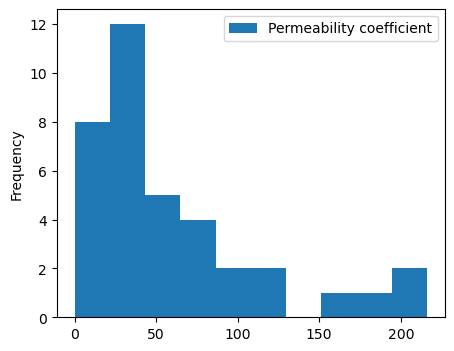

In [7]:
ax = df.plot.hist(column=["Permeability coefficient"], figsize=(5, 4))
ax

In [19]:
mols2grid.display(df, smiles_col="Canonical SMILES", size=(250, 150))

MolGridWidget()

In [15]:
#cleaning nulls in SMILES
df = df[(df['Canonical SMILES'].notnull())]

data_maestro = df[['Canonical SMILES', 'name']]
data_maestro.to_csv('data_maestro.csv', index=False)

In [20]:
list_antibiotics_before_docking = data_maestro['name'].tolist()
print('Number of compounds before docking: ' ,len(list_antibiotics_before_docking))

Number of compounds before docking:  33


## All antibiotic

In [10]:
name_antibiotic = '4-2'
if name_antibiotic in list_antibiotics_before_docking:
    print('This antibiotic is already exists in dataset')
    l = df[df['name'] == name_antibiotic]
else:
    print('This antibiotic does not exist in dataset')

This antibiotic is already exists in dataset


## Docking table

In [21]:
#reading initial data from maestro
dff = pd.read_csv('data_after_docking.csv', sep = ',')

In [22]:
dff.head(2)

,Stars,Title,Entry ID,Entry Name,Date Added,Date Modified,PDB TITLE,PDB ID,PDB CRYST1 a,PDB CRYST1 b,...,Volume File g0.80 r5.00,Void File g0.80 r5.00,Free Volume A^3 g0.55 r5.00,Free Volume % g0.55 r5.00,Volume File g0.55 r5.00,Void File g0.55 r5.00,Free Volume A^3 g0.30 r5.00,Free Volume % g0.30 r5.00,Volume File g0.30 r5.00,Void File g0.30 r5.00
0,NaN,Ceftriaxone,27228,data_maestro.22,2023-07-24 13:58:51,2023-07-24 13:58:51,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Nocardicin B,27229,data_maestro.29,2023-07-24 13:58:51,2023-07-24 13:58:51,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
#creating new data to work with
dff_new = dff.rename(columns={'Title': 'name'})

#cleaning empty columns 

columns = dff_new.columns
for x in columns:
    number_null = dff_new[x].isnull().sum()
    if number_null == dff_new.shape[0]:
        dff_new.drop(columns = [x], axis = 1, inplace=True)


#cleaning unnecesary columns 
dff_new.drop(columns = ['Entry ID', 'Entry Name', 'Date Added', 'Date Modified',
       'Source Path', 'Source File', 'Source File Index', 'Job Name', 'glide gridfile', 
       'source file', 'Force Field', 'flags', 'Chiralities Consistent','source file index', 
       'mmshare version', 'Variant', 'glide metal', 'glide eff state penalty', 'Energy', 
       'glide lignum', 'glide confnum', 'glide posenum', 'cmdline', 'tautomer probability',
       'Ionization Penalty', 'Ionization Penalty Charging', 'Ionization Penalty Neutral', 
       'State Penalty', 'Charging Adjusted Penalty', 'Tot Q', 'Tot abs Q', 'Chemistry Notes',
       'input'], axis = 1, inplace=True)


In [24]:
dff_new.shape

(570, 47)

In [25]:
print('Number of docked compounds: ' ,len(dff_new['name'].unique().tolist()))
print('Number of compounds in dataset: ' ,len(list_antibiotics_before_docking))

result_1 = list(set(list_antibiotics_before_docking).difference(dff_new['name'].unique().tolist()))
print('Compounds which were not docked: ', result_1)

mols2grid.display(df[df['name'].isin(result_1)], smiles_col="Canonical SMILES", size=(250, 150))

Number of docked compounds:  33
Number of compounds in dataset:  33
Compounds which were not docked:  []


MolGridWidget()

In [26]:
#ligand's numbers 

list_ligands = []
for x in dff_new.index.tolist():
    y = x+1
    list_ligands.append(y)
list_ligands

dff_new.insert(1, "Ligand", list_ligands)

In [27]:
list_antibiotics = dff_new['name'].unique().tolist()
#list_antibiotics

## Generating SMILEs string

In [28]:
list_SMILEs = []
with Chem.SDMolSupplier('structures_Nicado_sdf_fo_smiles.sdf') as suppl:
  ms = [x for x in suppl if x is not None]
for m in ms:
    #print(Chem.MolToSmiles(m))
    list_SMILEs.append(Chem.MolToSmiles(m))

dff_new.insert(0, "Canonical SMILES", list_SMILEs)  

dff_new.insert(2, "FormalCharge", [rdkit.Chem.rdmolops.GetFormalCharge(Chem.MolFromSmiles(x)) for x in dff_new['Canonical SMILES']]) 

In [29]:
dff_new.head()

,Canonical SMILES,name,FormalCharge,Ligand,glide rotatable bonds,docking score,glide ligand efficiency,glide ligand efficiency sa,glide ligand efficiency ln,glide gscore,...,res:A42 vdw,res:A42 coul,res:A42 hbond,res:A42 dist,res:A42 Eint,res:A16 vdw,res:A16 coul,res:A16 hbond,res:A16 dist,res:A16 Eint
0,CON=C(C(=O)N[C@H]1C(=O)N2C(C(=O)[O-])=C(CSc3nc...,Ceftriaxone,-2,1,9,-6.896,-0.192,-0.633,-1.505,-6.896,...,0.807,-70.377,-0.352,1.754,-69.922,4.290,-84.270,-0.149,1.499,-80.130
1,[NH3+][C@H](CCOc1ccc(C(=NO)C(=O)N[C@H]2CN([C@@...,Nocardicin B,-1,2,14,-6.720,-0.187,-0.616,-1.466,-6.720,...,-0.843,-38.531,-0.152,1.820,-39.526,2.856,-66.529,-0.168,1.744,-63.841
2,CC(=O)OCC1=C(C(=O)[O-])N2C(=O)[C@@H](NC(=O)CSc...,BL-S217,0,3,9,-6.613,-0.228,-0.701,-1.514,-6.613,...,1.399,-40.435,-0.370,1.715,-39.405,-0.958,-37.269,-0.235,1.858,-38.462
3,[NH3+][C@H](CCOc1ccc(C(=NO)C(=O)N[C@H]2CN([C@@...,Nocardicin B,-1,4,14,-6.518,-0.181,-0.598,-1.422,-6.518,...,-1.440,-37.918,-0.160,1.947,-39.518,4.049,-69.752,-0.243,1.788,-65.946
4,CC(C)(ON=C(C(=O)N[C@@H]1C(=O)N2C(C(=O)[O-])=C(...,Ceftazidime,-1,5,10,-6.468,-0.175,-0.582,-1.403,-6.468,...,3.926,-63.485,-0.359,1.597,-59.918,-3.268,-45.181,0.000,2.550,-48.449


# Descriptors alvaDesc

In [30]:
charge_descr = pd.read_csv(r'C:\Users\olshana1\Git\GramNeg-Accumulation\Gram Negative Permeation - OmpF\Descriptors/27 - Charge descriptors.txt', sep = '	')
charge_descr

,No.,NAME,qpmax,qnmax,Qpos,Qtot,Qmean,Q2,RPCG,RNCG,LDI
0,1,Ceftriaxone,0.298098,-0.843070,3.462778,8.925556,0.171645,2.769369,0.086086,0.154330,0.272625
1,2,Nocardicin B,0.345468,-0.845945,4.639714,10.279429,0.174228,3.722354,0.074459,0.149998,0.261989
2,3,BL-S217,0.304250,-0.843070,3.483908,6.967816,0.145163,2.002845,0.087330,0.241990,0.216123
3,4,Nocardicin B,0.345468,-0.845945,4.639714,10.279429,0.174228,3.722354,0.074459,0.149998,0.261989
4,5,Ceftazidime,0.276392,-0.844834,4.027068,9.054137,0.156106,2.957134,0.068633,0.168057,0.240668
...,...,...,...,...,...,...,...,...,...,...,...
565,566,Ceftriaxone,0.298098,-0.843070,3.462778,8.925556,0.171645,2.769369,0.086086,0.154330,0.272625
566,567,Cephalothin,0.304250,-0.843070,2.417855,5.835710,0.142334,1.825433,0.125835,0.246666,0.220919
567,568,Cefotaxime,0.304250,-0.843070,3.323309,7.646618,0.166231,2.322427,0.091550,0.195006,0.268591
568,569,Cephalothin,0.304250,-0.843070,2.417855,5.835710,0.142334,1.825433,0.125835,0.246666,0.220919


## Interaction Fingerprints

The following interactions were analyzed: hydrogen bonds (HAccep, HDonor and Ar-Hbond), halogen bonds (XBond), salt-bridge interactions (Salt), π-cation interactions (PiCat), π-π interactions (PiFace, PiEdge) and hydrophobic interactions (HPhob)

In [31]:
int_table = pd.read_csv('glide-dock_Nicaido_neutral_pv_interactions.csv', sep = ',')

In [32]:
int_table

,Type,Ligand,Title,LigResidue,LigAtom,RecResidue,RecAtom,Dist
0,HAccep cn,1,Ceftriaxone,_:900(UNK),12( ),A:42(ARG),2924(HH22),1.880
1,HAccep nn,1,Ceftriaxone,_:900(UNK),23( ),A:132(ARG),3544(HH12),1.616
2,HAccep cn,1,Ceftriaxone,_:900(UNK),25( ),A:132(ARG),3546(HH22),2.250
3,HAccep nc,1,Ceftriaxone,_:900(UNK),29( ),A:42(ARG),2922(HH12),1.754
4,HAccep cn,1,Ceftriaxone,_:900(UNK),30( ),A:16(LYS),2753( HZ2),1.499
...,...,...,...,...,...,...,...,...
5016,PiEdge,462,Cephalothin,_:900(UNK),15( ),A:118(PHE),910( CG ),5.358
5017,PiEdge,493,Nalidixic acid,_:900(UNK),3( ),A:14(TYR),109( CG ),5.476
5018,PiEdge,514,Cefoxitin,_:900(UNK),23( ),A:14(TYR),109( CG ),5.343
5019,PiEdge,521,Cefoxitin,_:900(UNK),23( ),A:14(TYR),109( CG ),5.243


In [34]:
interactions = int_table.rename(columns={'Title': 'name'})

interactions.drop(columns = ['LigResidue','LigAtom', 'RecAtom'], axis = 1, inplace=True)
#interactions

interactions

,Type,Ligand,name,RecResidue,Dist
0,HAccep cn,1,Ceftriaxone,A:42(ARG),1.880
1,HAccep nn,1,Ceftriaxone,A:132(ARG),1.616
2,HAccep cn,1,Ceftriaxone,A:132(ARG),2.250
3,HAccep nc,1,Ceftriaxone,A:42(ARG),1.754
4,HAccep cn,1,Ceftriaxone,A:16(LYS),1.499
...,...,...,...,...,...
5016,PiEdge,462,Cephalothin,A:118(PHE),5.358
5017,PiEdge,493,Nalidixic acid,A:14(TYR),5.476
5018,PiEdge,514,Cefoxitin,A:14(TYR),5.343
5019,PiEdge,521,Cefoxitin,A:14(TYR),5.243


In [41]:
# number of found residues after docking

jkj = interactions['RecResidue'].unique().tolist()
len(jkj)

42

In [42]:
#types of found interactions

binds = interactions['Type'].unique().tolist()
print(len(binds))
binds

13


['HAccep cn',
 'HAccep nn',
 'HAccep nc',
 'HDonor nn',
 'HAccep cc',
 'HDonor nc',
 'HDonor cn',
 'HDonor cc',
 'Salt',
 'HPhob',
 'PiFace',
 'XBond',
 'PiEdge']

In [37]:
table_int = pd.pivot_table(interactions, values='Type', index=['name', 'Ligand'], columns=['RecResidue'], aggfunc = np.sum, fill_value=0)

In [38]:
table_int

RecResidue           A:101(ASN) A:102(TYR) A:106(TYR) A:110(GLY) A:113(ASP)  \
name          Ligand                                                          
Ampicillin    133             0          0          0          0  HDonor nn   
              203             0          0          0          0          0   
              312             0          0          0          0          0   
              341             0          0          0          0          0   
              360             0          0          0          0          0   
...                         ...        ...        ...        ...        ...   
Sulbenicillin 452             0          0          0          0          0   
              468             0          0          0          0          0   
              480             0          0          0          0          0   
              526             0          0          0          0          0   
              535             0          0          0          0          0   

RecResidue           A:114(MET) A:115(LEU) A:116(PRO)          A:117(GLU)  \
name          Ligand                                                        
Ampicillin    133             0          0          0                   0   
              203             0          0          0  HDonor nnHDonor cn   
              312             0          0          0           HDonor cn   
              341             0          0          0  HDonor cnHDonor cn   
              360             0          0          0           HDonor cn   
...                         ...        ...        ...                 ...   
Sulbenicillin 452             0          0          0                   0   
              468             0          0          0                   0   
              480             0          0          0                   0   
              526             0          0          0                   0   
              535             0          0          0                   0   

RecResidue           A:118(PHE)  ...               A:42(ARG) A:46(LYS)  \
name          Ligand             ...                                     
Ampicillin    133             0  ...  HAccep ncHAccep ccSalt         0   
              203             0  ...               HAccep cn         0   
              312             0  ...      HAccep cnHAccep nn         0   
              341             0  ...               HAccep cn         0   
              360             0  ...      HAccep cnHAccep nn         0   
...                         ...  ...                     ...       ...   
Sulbenicillin 452             0  ...               HAccep nc         0   
              468             0  ...  HAccep ncHAccep ccSalt         0   
              480             0  ...           HAccep ccSalt         0   
              526             0  ...               HAccep nn         0   
              535             0  ...  HAccep ncHAccep ccSalt         0   

RecResidue           A:60(GLN) A:62(GLU) A:64(ASN) A:66(GLN)  A:80(LYS)  \
name          Ligand                                                      
Ampicillin    133            0         0         0         0          0   
              203            0         0         0         0          0   
              312            0         0         0         0          0   
              341            0         0         0         0          0   
              360            0         0         0         0          0   
...                        ...       ...       ...       ...        ...   
Sulbenicillin 452            0         0         0         0  HAccep cn   
              468            0         0         0         0  HAccep cn   
              480            0         0         0         0  HAccep cn   
              526            0         0         0         0          0   
              535            0         0         0         0          0   

RecResidue                     

In [39]:
interaction_residues = table_int.columns
interaction_residues

Index(['A:101(ASN)', 'A:102(TYR)', 'A:106(TYR)', 'A:110(GLY)', 'A:113(ASP)',
       'A:114(MET)', 'A:115(LEU)', 'A:116(PRO)', 'A:117(GLU)', 'A:118(PHE)',
       'A:119(GLY)', 'A:120(GLY)', 'A:121(ASP)', 'A:123(ALA)', 'A:124(TYR)',
       'A:125(SER)', 'A:132(ARG)', 'A:14(TYR)', 'A:15(GLY)', 'A:16(LYS)',
       'A:167(ARG)', 'A:168(ARG)', 'A:20(LEU)', 'A:22(TYR)', 'A:300(THR)',
       'A:302(TYR)', 'A:310(TYR)', 'A:337(VAL)', 'A:339(GLN)', 'A:340(PHE)',
       'A:38(MET)', 'A:40(TYR)', 'A:42(ARG)', 'A:46(LYS)', 'A:60(GLN)',
       'A:62(GLU)', 'A:64(ASN)', 'A:66(GLN)', 'A:80(LYS)', 'A:82(ARG)',
       'A:83(LEU)', 'A:85(PHE)'],
      dtype='object', name='RecResidue')

In [43]:
#interaction fingerpronts for each residue

for x in range(table_int.shape[0]):
    for y in range(table_int.shape[1]):
        cell = str(table_int.iloc[x, y])
        #print(cell)
        list_int = []
        for bond in binds:
            if bond in cell:
                #print('YES', bond)
                list_int.append("1")
            else:
                list_int.append("0")
        #print(list_int)
        table_int.iloc[x,y] =  " ".join(list_int)
        #table_int.iloc[x,y] = list_int

In [44]:
#format column names
table_int.columns = [''.join(str(s).strip() for s in col if s) for col in table_int.columns]

#reset index
table_int.reset_index(inplace=True)

In [45]:
table_int.head(10)

,name,Ligand,A:101(ASN),A:102(TYR),A:106(TYR),A:110(GLY),A:113(ASP),A:114(MET),A:115(LEU),A:116(PRO),...,A:42(ARG),A:46(LYS),A:60(GLN),A:62(GLU),A:64(ASN),A:66(GLN),A:80(LYS),A:82(ARG),A:83(LEU),A:85(PHE)
0,Ampicillin,133,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 1 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,...,0 0 1 0 1 0 0 0 1 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,1 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0
1,Ampicillin,203,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,...,1 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 1 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0
2,Ampicillin,312,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,...,1 1 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 1 0 0 0 1 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0
3,Ampicillin,341,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,...,1 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 1 0 0 0 0 0 1 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0
4,Ampicillin,360,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,...,1 1 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 1 0 1 0 0 0 1 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0
5,Ampicillin,394,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,...,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 1 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0
6,Ampicillin,443,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,...,1 0 1 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 1 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0
7,Ampicillin,454,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 1 0 0 1 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,...,1 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0

In [46]:
# interaction_1Dstring

residues = table_int.columns.tolist()

table_int['interaction_1Dstring'] = 0

for x in range(table_int.shape[0]):
    oneD_int = []
    for y in residues[2:]:
        cell_1 = table_int.loc[x,y]
        oneD_int.append(cell_1)
        
    table_int.loc[x, 'interaction_1Dstring'] = " ".join(oneD_int)
    #table_int.loc[x, 'interaction_1Dstring'] = oneD_int

In [47]:
# number of bits, number of residues * types of interactions

len(table_int.loc[2456, 'interaction_1Dstring'].split(' '))

KeyError: 2456

In [33]:
FINAL = pd.merge(dff_new, table_int,  how='left', left_on=['name','Ligand'], right_on = ['name','Ligand'])

In [34]:
FINAL.head()

,Canonical SMILES,name,FormalCharge,Ligand,glide rotatable bonds,docking score,glide ligand efficiency,glide ligand efficiency sa,glide ligand efficiency ln,glide gscore,...,A:46(LYS),A:60(GLN),A:62(GLU),A:64(ASN),A:66(GLN),A:80(LYS),A:82(ARG),A:83(LEU),A:85(PHE),interaction_1Dstring
0,C=C1C[C@]23C[C@@]1(O)CC[C@H]2[C@@]12C=C[C@@H](...,2-6,2,1,2,-6.671,-0.278,-0.802,-1.597,-6.769,...,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1,C=C1C[C@]23C[C@@]1(O)CC[C@H]2[C@@]12C=C[C@@H](...,2-6,2,2,2,-6.615,-0.276,-0.795,-1.583,-6.712,...,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
2,COc1ccc2c(c1O)[C@@]13CC[NH2+][C@@H](C2)[C@H]1C...,2-11,2,3,3,-6.506,-0.283,-0.804,-1.573,-6.506,...,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
3,C=C1C[C@]23C[C@@]1(O)CC[C@H]2[C@@]12C=C[C@@H](...,2-6,2,4,2,-6.377,-0.266,-0.766,-1.526,-6.475,...,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
4,C=C1C[C@]23C[C@@]1(O)CC[C@H]2[C@@]12C=C[C@@H](...,2-6,2,5,2,-6.306,-0.263,-0.758,-1.509,-6.404,...,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


# Data for machine learning course

In [35]:
data_course = FINAL.copy()
data_course.head()

,Canonical SMILES,name,FormalCharge,Ligand,glide rotatable bonds,docking score,glide ligand efficiency,glide ligand efficiency sa,glide ligand efficiency ln,glide gscore,...,A:46(LYS),A:60(GLN),A:62(GLU),A:64(ASN),A:66(GLN),A:80(LYS),A:82(ARG),A:83(LEU),A:85(PHE),interaction_1Dstring
0,C=C1C[C@]23C[C@@]1(O)CC[C@H]2[C@@]12C=C[C@@H](...,2-6,2,1,2,-6.671,-0.278,-0.802,-1.597,-6.769,...,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1,C=C1C[C@]23C[C@@]1(O)CC[C@H]2[C@@]12C=C[C@@H](...,2-6,2,2,2,-6.615,-0.276,-0.795,-1.583,-6.712,...,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
2,COc1ccc2c(c1O)[C@@]13CC[NH2+][C@@H](C2)[C@H]1C...,2-11,2,3,3,-6.506,-0.283,-0.804,-1.573,-6.506,...,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
3,C=C1C[C@]23C[C@@]1(O)CC[C@H]2[C@@]12C=C[C@@H](...,2-6,2,4,2,-6.377,-0.266,-0.766,-1.526,-6.475,...,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
4,C=C1C[C@]23C[C@@]1(O)CC[C@H]2[C@@]12C=C[C@@H](...,2-6,2,5,2,-6.306,-0.263,-0.758,-1.509,-6.404,...,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


In [36]:
#cleaning unnecesary columns 
data_course.drop(columns = ['FormalCharge', 'glide rotatable bonds',
 'docking score',
 'glide ligand efficiency',
 'glide ligand efficiency sa',
 'glide ligand efficiency ln',
 'glide gscore',
 'glide lipo',
 'glide hbond',
 'glide rewards',
 'glide evdw',
 'glide ecoul',
 'glide erotb',
 'glide esite',
 'glide emodel',
 'glide energy',
 'glide einternal',
 'res:A132 vdw',
 'res:A132 coul',
 'res:A132 hbond',
 'res:A132 dist',
 'res:A132 Eint',
 'res:A117 vdw',
 'res:A117 coul',
 'res:A117 hbond',
 'res:A117 dist',
 'res:A117 Eint',
 'res:A113 vdw',
 'res:A113 coul',
 'res:A113 hbond',
 'res:A113 dist',
 'res:A113 Eint',
 'res:A82 vdw',
 'res:A82 coul',
 'res:A82 hbond',
 'res:A82 dist',
 'res:A82 Eint',
 'res:A42 vdw',
 'res:A42 coul',
 'res:A42 hbond',
 'res:A42 dist',
 'res:A42 Eint',
 'res:A16 vdw',
 'res:A16 coul',
 'res:A16 hbond',
 'res:A16 dist',
 'res:A16 Eint', 'interaction_1Dstring'], axis = 1, inplace=True)

In [37]:
data_course.shape

(2605, 59)

In [38]:
data_course.head(2)

,Canonical SMILES,name,Ligand,A:1(ALA),A:101(ASN),A:102(TYR),A:106(TYR),A:107(ASP),A:110(GLY),A:111(TYR),...,A:42(ARG),A:46(LYS),A:60(GLN),A:62(GLU),A:64(ASN),A:66(GLN),A:80(LYS),A:82(ARG),A:83(LEU),A:85(PHE)
0,C=C1C[C@]23C[C@@]1(O)CC[C@H]2[C@@]12C=C[C@@H](...,2-6,1,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,...,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0
1,C=C1C[C@]23C[C@@]1(O)CC[C@H]2[C@@]12C=C[C@@H](...,2-6,2,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,...,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0


In [39]:
dict_new = {}

#chargee = []
coef = []
classs = []
namee = []


for indd in data_course.index:
    name1 = data_course.loc[indd, 'name']
    exp_values = df[df['name'] == name1]

    indd_2 = list(exp_values.index)
    #namee.append(name1)
    #chargee.append(exp_values.loc[indd_2[0], 'Charge'])
    coef.append(exp_values.loc[indd_2[0], 'Permeability coefficient'])
    classs.append(exp_values.loc[indd_2[0], 'Accum_class'])

#dict_new['name'] = namee
dict_new['Permeability coefficient'] = coef
dict_new['Accumulation_class'] = classs
#dict_new['Charge'] = chargee

data_numb = pd.DataFrame(dict_new)
print(data_numb.shape)
data_numb


(2605, 2)


,Permeability coefficient,Accumulation_class
0,504.0,High
1,504.0,High
2,204.0,Low
3,504.0,High
4,504.0,High
...,...,...
2600,139.0,Low
2601,628.0,High
2602,139.0,Low
2603,139.0,Low


In [41]:
result = pd.concat([data_numb, data_course], axis=1)
result.insert(4, "FormalCharge", [rdkit.Chem.rdmolops.GetFormalCharge(Chem.MolFromSmiles(x)) for x in result['Canonical SMILES']]) 
result

,Permeability coefficient,Accumulation_class,Canonical SMILES,name,FormalCharge,Ligand,A:1(ALA),A:101(ASN),A:102(TYR),A:106(TYR),...,A:42(ARG),A:46(LYS),A:60(GLN),A:62(GLU),A:64(ASN),A:66(GLN),A:80(LYS),A:82(ARG),A:83(LEU),A:85(PHE)
0,504.0,High,C=C1C[C@]23C[C@@]1(O)CC[C@H]2[C@@]12C=C[C@@H](...,2-6,2,1,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,...,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0
1,504.0,High,C=C1C[C@]23C[C@@]1(O)CC[C@H]2[C@@]12C=C[C@@H](...,2-6,2,2,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,...,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0
2,204.0,Low,COc1ccc2c(c1O)[C@@]13CC[NH2+][C@@H](C2)[C@H]1C...,2-11,2,3,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,...,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0
3,504.0,High,C=C1C[C@]23C[C@@]1(O)CC[C@H]2[C@@]12C=C[C@@H](...,2-6,2,4,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,...,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0
4,504.0,High,C=C1C[C@]23C[C@@]1(O)CC[C@H]2[C@@]12C=C[C@@H](...,2-6,2,5,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,...,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2600,139.0,Low,C=CCO[C@@H]1CO[C@H]2[C@@H]1OC[C@H]2OCC=C,2-62,0,2601,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,...,0 0 0 1 0 0 0 0 0 0 0 0 0 1,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 1,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0
2601,628.0,High,C[C@@H]1[C@H](O)[C@](C)(C[NH3+])C[C@@H](OC(=O)...,4-16,1,2602,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,...,0 0 0 1 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,1 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0
2602,139.0,Low,C=CCO[C@@H]1CO[C@H]2[C@@H]1OC[C@H]2OCC=C,2-62,0,2603,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,...,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 

In [44]:
result.to_csv(r'C:\Users\olshana1\Git\GramNeg-Accumulation\machine learning course/data_final_project.csv', index=False, header=True)

## Continue to work with FINAL dataframe (no course)

In [90]:
for_nan = FINAL.loc[0, 'A:46(LYS)']
true_false = FINAL.isnull()

In [91]:
true_false

,Canonical SMILES,name,FormalCharge,Ligand,glide rotatable bonds,docking score,glide ligand efficiency,glide ligand efficiency sa,glide ligand efficiency ln,glide gscore,...,A:46(LYS),A:60(GLN),A:62(GLU),A:64(ASN),A:66(GLN),A:80(LYS),A:82(ARG),A:83(LEU),A:85(PHE),interaction_1Dstring
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2600,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2601,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2602,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2603,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [92]:
for sample in true_false.index:
    for feature_1 in true_false.columns.tolist():
        if true_false.loc[sample, feature_1] == True:
            #print(sample, feature_1)
            FINAL.loc[sample, feature_1] = for_nan

In [93]:
FINAL.head()

,Canonical SMILES,name,FormalCharge,Ligand,glide rotatable bonds,docking score,glide ligand efficiency,glide ligand efficiency sa,glide ligand efficiency ln,glide gscore,...,A:46(LYS),A:60(GLN),A:62(GLU),A:64(ASN),A:66(GLN),A:80(LYS),A:82(ARG),A:83(LEU),A:85(PHE),interaction_1Dstring
0,C=C1C[C@]23C[C@@]1(O)CC[C@H]2[C@@]12C=C[C@@H](...,2-6,2,1,2,-6.671,-0.278,-0.802,-1.597,-6.769,...,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1,C=C1C[C@]23C[C@@]1(O)CC[C@H]2[C@@]12C=C[C@@H](...,2-6,2,2,2,-6.615,-0.276,-0.795,-1.583,-6.712,...,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
2,COc1ccc2c(c1O)[C@@]13CC[NH2+][C@@H](C2)[C@H]1C...,2-11,2,3,3,-6.506,-0.283,-0.804,-1.573,-6.506,...,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
3,C=C1C[C@]23C[C@@]1(O)CC[C@H]2[C@@]12C=C[C@@H](...,2-6,2,4,2,-6.377,-0.266,-0.766,-1.526,-6.475,...,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
4,C=C1C[C@]23C[C@@]1(O)CC[C@H]2[C@@]12C=C[C@@H](...,2-6,2,5,2,-6.306,-0.263,-0.758,-1.509,-6.404,...,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


In [94]:
FINAL.isnull().sum()

Canonical SMILES         0
name                     0
FormalCharge             0
Ligand                   0
glide rotatable bonds    0
                        ..
A:80(LYS)                0
A:82(ARG)                0
A:83(LEU)                0
A:85(PHE)                0
interaction_1Dstring     0
Length: 107, dtype: int64

In [95]:
FINAL.shape

(2605, 107)

In [96]:
FINAL.to_csv(r'C:\Users\olshana1\Git\GramNeg-Accumulation\work with NATURE dataset - neutral molecules\Gram Negative Permeation - OmpF- applying for Nature_data_neutral_charge/FINAL.csv', index=False, header=True)

### Generating new names: residue+interaction's type

In [100]:
columns_bit_string = []
for property in FINAL.columns.tolist():
    if ((property[0] == 'A') and (property[-1] == ')')):
        columns_bit_string.append(property)

len(columns_bit_string)

56

In [101]:
new_columns_names = []

for residue in columns_bit_string:
    for type in binds:
        bit = residue + ' ' + type
        new_columns_names.append(bit)

len(new_columns_names)

784

In [104]:
list_new_table = []
for p in FINAL.index:
    oneD_int = []
    for y in columns_bit_string:
        cell_1 = FINAL.loc[p,y]
        oneD_int.append(cell_1)
    
    list_new_table.append(" ".join(oneD_int).split(sep=" ", maxsplit=-1))


In [105]:
df2 = pd.DataFrame(np.array(list_new_table), columns=new_columns_names)
df2

,A:1(ALA) HDonor nc,A:1(ALA) HDonor cc,A:1(ALA) HAccep cn,A:1(ALA) HAccep nn,A:1(ALA) HAccep nc,A:1(ALA) HAccep cc,A:1(ALA) HDonor nn,A:1(ALA) HDonor cn,A:1(ALA) XBond,A:1(ALA) Salt,...,A:85(PHE) HAccep nc,A:85(PHE) HAccep cc,A:85(PHE) HDonor nn,A:85(PHE) HDonor cn,A:85(PHE) XBond,A:85(PHE) Salt,A:85(PHE) PiCat,A:85(PHE) PiFace,A:85(PHE) PiEdge,A:85(PHE) HPhob
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2600,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2601,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2602,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2603,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [106]:
machine_learn_to_work = pd.concat([FINAL, df2], axis=1)
machine_learn_to_work.drop(columns=columns_bit_string, inplace=True)

machine_learn_to_work

,Canonical SMILES,name,FormalCharge,Ligand,glide rotatable bonds,docking score,glide ligand efficiency,glide ligand efficiency sa,glide ligand efficiency ln,glide gscore,...,A:85(PHE) HAccep nc,A:85(PHE) HAccep cc,A:85(PHE) HDonor nn,A:85(PHE) HDonor cn,A:85(PHE) XBond,A:85(PHE) Salt,A:85(PHE) PiCat,A:85(PHE) PiFace,A:85(PHE) PiEdge,A:85(PHE) HPhob
0,C=C1C[C@]23C[C@@]1(O)CC[C@H]2[C@@]12C=C[C@@H](...,2-6,2,1,2,-6.671,-0.278,-0.802,-1.597,-6.769,...,0,0,0,0,0,0,0,0,0,0
1,C=C1C[C@]23C[C@@]1(O)CC[C@H]2[C@@]12C=C[C@@H](...,2-6,2,2,2,-6.615,-0.276,-0.795,-1.583,-6.712,...,0,0,0,0,0,0,0,0,0,0
2,COc1ccc2c(c1O)[C@@]13CC[NH2+][C@@H](C2)[C@H]1C...,2-11,2,3,3,-6.506,-0.283,-0.804,-1.573,-6.506,...,0,0,0,0,0,0,0,0,0,0
3,C=C1C[C@]23C[C@@]1(O)CC[C@H]2[C@@]12C=C[C@@H](...,2-6,2,4,2,-6.377,-0.266,-0.766,-1.526,-6.475,...,0,0,0,0,0,0,0,0,0,0
4,C=C1C[C@]23C[C@@]1(O)CC[C@H]2[C@@]12C=C[C@@H](...,2-6,2,5,2,-6.306,-0.263,-0.758,-1.509,-6.404,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2600,C=CCO[C@@H]1CO[C@H]2[C@@H]1OC[C@H]2OCC=C,2-62,0,2601,6,0.301,0.019,0.047,0.080,0.301,...,0,0,0,0,0,0,0,0,0,0
2601,C[C@@H]1[C@H](O)[C@](C)(C[NH3+])C[C@@H](OC(=O)...,4-16,1,2602,6,0.338,0.013,0.038,0.079,0.338,...,0,0,0,0,0,0,0,0,0,0
2602,C=CCO[C@@H]1CO[C@H]2[C@@H]1OC[C@H]2OCC=C,2-62,0,2603,6,0.359,0.022,0.056,0.095,0.359,...,0,0,0,0,0,0,0,0,0,0
2603,C=CCO[C@@H]1CO[C@H]2[C@@H]1OC[C@H]2OCC=C,2-62,0,2604,6,0.367,0.023,0.058,0.097,0.367,...,0,0,0,0,0,0,0,0,0,0


In [109]:
ready_to_vote = pd.concat([data_numb, machine_learn_to_work], axis=1)
ready_to_vote

,Permeability coefficient,Accumulation_class,Charge,Canonical SMILES,name,FormalCharge,Ligand,glide rotatable bonds,docking score,glide ligand efficiency,...,A:85(PHE) HAccep nc,A:85(PHE) HAccep cc,A:85(PHE) HDonor nn,A:85(PHE) HDonor cn,A:85(PHE) XBond,A:85(PHE) Salt,A:85(PHE) PiCat,A:85(PHE) PiFace,A:85(PHE) PiEdge,A:85(PHE) HPhob
0,504.0,High,+ +,C=C1C[C@]23C[C@@]1(O)CC[C@H]2[C@@]12C=C[C@@H](...,2-6,2,1,2,-6.671,-0.278,...,0,0,0,0,0,0,0,0,0,0
1,504.0,High,+ +,C=C1C[C@]23C[C@@]1(O)CC[C@H]2[C@@]12C=C[C@@H](...,2-6,2,2,2,-6.615,-0.276,...,0,0,0,0,0,0,0,0,0,0
2,204.0,Low,+ +,COc1ccc2c(c1O)[C@@]13CC[NH2+][C@@H](C2)[C@H]1C...,2-11,2,3,3,-6.506,-0.283,...,0,0,0,0,0,0,0,0,0,0
3,504.0,High,+ +,C=C1C[C@]23C[C@@]1(O)CC[C@H]2[C@@]12C=C[C@@H](...,2-6,2,4,2,-6.377,-0.266,...,0,0,0,0,0,0,0,0,0,0
4,504.0,High,+ +,C=C1C[C@]23C[C@@]1(O)CC[C@H]2[C@@]12C=C[C@@H](...,2-6,2,5,2,-6.306,-0.263,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2600,139.0,Low,neutral,C=CCO[C@@H]1CO[C@H]2[C@@H]1OC[C@H]2OCC=C,2-62,0,2601,6,0.301,0.019,...,0,0,0,0,0,0,0,0,0,0
2601,628.0,High,+,C[C@@H]1[C@H](O)[C@](C)(C[NH3+])C[C@@H](OC(=O)...,4-16,1,2602,6,0.338,0.013,...,0,0,0,0,0,0,0,0,0,0
2602,139.0,Low,neutral,C=CCO[C@@H]1CO[C@H]2[C@@H]1OC[C@H]2OCC=C,2-62,0,2603,6,0.359,0.022,...,0,0,0,0,0,0,0,0,0,0
2603,139.0,Low,neutral,C=CCO[C@@H]1CO[C@H]2[C@@H]1OC[C@H]2OCC=C,2-62,0,2604,6,0.367,0.023,...,0,0,0,0,0,0,0,0,0,0


In [110]:
ready_to_vote.to_csv(r'C:\Users\olshana1\Git\GramNeg-Accumulation\work with NATURE dataset - neutral molecules\Gram Negative Permeation - OmpF- applying for Nature_data_neutral_charge/ready_to_vote.csv', index=False, header=True)

## STOPPED HERE

# Taking a pose based on interaction fingerprints 

## Voting based on majority of the interaction existence
#### FINAL_pose1 dataframe

In [200]:
#new dataframe 

new_col_t = table_int.columns.tolist()
new_col_t.remove('Ligand')
new_col_t.remove('interaction_1Dstring')

FINAL_pose1 = pd.DataFrame(columns=new_col_t)
FINAL_pose1['name'] = list_antibiotics


In [201]:
for antibiotic in list_antibiotics:
    for residue in new_col_t[1:]:

        #take antibiotic 
        test_ant = FINAL.loc[FINAL['name'] == antibiotic, [residue]]

        #take residue
        test_dat = pd.DataFrame(columns=list(range(1, len(binds)+1)))
        for bit_str in test_ant[residue]:
            test_dat.loc[len(test_dat)] = bit_str.split(' ')

        #voting
        ones_ziros = []
        for col in range(1, len(binds)+1):
            ones = 0
            for bit in test_dat.loc[:, col]:
                if bit == '1':
                    ones = ones + 1
            ones_ziros.append(ones)

        #generating new string 
        cut_off = test_dat.shape[0]/2

        list_bits_new = []
        for sum in ones_ziros:
            if sum > cut_off:
                list_bits_new.append("1")
            else:
                list_bits_new.append("0")
        
        gfg = " ".join(list_bits_new)

        FINAL_pose1.loc[FINAL_pose1['name'] == antibiotic, [residue]] = gfg
        #print(antibiotic, residue, gfg)


In [202]:
FINAL_pose1

,name,A:1(ALA),A:102(TYR),A:106(TYR),A:107(ASP),A:110(GLY),A:111(TYR),A:113(ASP),A:114(MET),A:115(LEU),...,A:42(ARG),A:46(LYS),A:60(GLN),A:62(GLU),A:64(ASN),A:66(GLN),A:80(LYS),A:82(ARG),A:83(LEU),A:85(PHE)
0,Ampcillin,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 1 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,...,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,1 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0
1,4-43,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 1 1 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,...,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0
2,4-45,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,...,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0
3,4-28a,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 1 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,...,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0
4,4-55a,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,...,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 1 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,4-29,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,...,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0
184,3-52,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,...,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0

## Voting based on at least ONE interaction existence
#### FINAL_pose3 dataframe

In [203]:
FINAL_pose3 = pd.DataFrame(columns=new_col_t)
FINAL_pose3['name'] = list_antibiotics

In [204]:
for antibiotic in list_antibiotics:
    for residue in new_col_t[1:]:

        #take antibiotic 
        test_ant = FINAL.loc[FINAL['name'] == antibiotic, [residue]]

        #take residue
        test_dat = pd.DataFrame(columns=list(range(1, len(binds)+1)))
        for bit_str in test_ant[residue]:
            test_dat.loc[len(test_dat)] = bit_str.split(' ')

        #voting
        ones_ziros = []
        for col in range(1, len(binds)+1):
            ones = 0
            for bit in test_dat.loc[:, col]:
                if bit == '1':
                    ones = ones + 1
            ones_ziros.append(ones)

        list_bits_new = []
        for sum in ones_ziros:
            if sum > 0:
                list_bits_new.append("1")
            else:
                list_bits_new.append("0")
        
        gfg = " ".join(list_bits_new)

        FINAL_pose3.loc[FINAL_pose3['name'] == antibiotic, [residue]] = gfg
        #print(antibiotic, residue, gfg)


## Taking the low energy pose for each lingand
#### FINAL_pose2 dataframe

In [205]:
#empty DataFrame
FINAL_pose2 = pd.DataFrame(columns = FINAL.columns)

#adding pose with low energy
for x in list_antibiotics:
    x = FINAL[FINAL['name'] == x]
    min_glide_gscore= x['glide gscore'].min()
    l = x[x['glide gscore'] == min_glide_gscore]
    FINAL_pose2 = pd.concat([FINAL_pose2, l])

## Charge, Permeability coefficient, ASP113 for all experiments

In [206]:
list_experiments = [FINAL_pose1, FINAL_pose2, FINAL_pose3]
important_residues = ['A:113(ASP)', 'A:117(GLU)', 'A:16(LYS)', 'A:42(ARG)', 'A:82(ARG)', 'A:132(ARG)']

for experiment in list_experiments:

    list_charge = []
    list_Permeability_coefficient = []
    list_Canonical_SMILES = []

    for x in experiment['name']:
        string = df[df['name'] == x]
        charge = string['Charge'].values
        Permeability_coefficient = int(string['Permeability coefficient'])
        Canonical_SMILES = string['Canonical SMILES'].values
        
        list_charge.append(charge[0])
        list_Permeability_coefficient.append(Permeability_coefficient)
        list_Canonical_SMILES.append(Canonical_SMILES[0])

    experiment.insert(1, "Permeability coefficient", list_Permeability_coefficient, False)
    experiment.insert(2, "Charge", list_charge, False)
    experiment.insert(experiment.shape[1], "Canonical SMILES" , list_Canonical_SMILES, False)

    #all important bonds

    for residue in important_residues:
        bond = '_bond'
        experiment[residue + bond] = 0
        for p in experiment.index:
            string = experiment.loc[p, residue]
            a113_number = 0
            for y in string:
                if y == '1':
                    a113_number = a113_number + 1
                else:
                    a113_number = a113_number + 0
        
            if  a113_number > 0:
                experiment.loc[p, residue + bond] = "1"
            else:
                experiment.loc[p, residue + bond] = "0"

C:\Users\olshana1\AppData\Local\Temp\ipykernel_19052\2013265626.py:13: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  Permeability_coefficient = int(string['Permeability coefficient'])
C:\Users\olshana1\AppData\Local\Temp\ipykernel_19052\2013265626.py:13: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  Permeability_coefficient = int(string['Permeability coefficient'])
C:\Users\olshana1\AppData\Local\Temp\ipykernel_19052\2013265626.py:13: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  Permeability_coefficient = int(string['Permeability coefficient'])


In [207]:
FINAL_pose1.to_csv(r'C:\Users\olshana1\Documents\new-progect-about-gram-negative-bacteria-main\work with NATURE dataset\Gram Negative Permeation - OmpF- applying for Nature_data/FINAL_pose1.csv', index=False, header=True)
FINAL_pose2.to_csv(r'C:\Users\olshana1\Documents\new-progect-about-gram-negative-bacteria-main\work with NATURE dataset\Gram Negative Permeation - OmpF- applying for Nature_data/FINAL_pose2.csv', index=False, header=True)
FINAL_pose3.to_csv(r'C:\Users\olshana1\Documents\new-progect-about-gram-negative-bacteria-main\work with NATURE dataset\Gram Negative Permeation - OmpF- applying for Nature_data/FINAL_pose3.csv', index=False, header=True)

#### FINAL - dataframe with all poses
#### FINAL_pose1 - Taking a pose based on interaction fingerprints (based on the majority)
#### FINAL_pose2 - Taking the low energy pose for each lingand
#### FINAL_pose3 dataframe - Voting based on at least ONE interaction existence